In [1]:
%load_ext autoreload
%autoreload 2

import os
import params
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.io import loadmat
from PIL import Image
import scipy
from time import sleep
from collections import defaultdict


In [2]:
def get_ellipse(parameters,factor=1.5):
    amplitude, x0, y0, sigma_x, sigma_y, theta = parameters
    width = factor * 2.0 * sigma_x
    height = factor * 2.0 * sigma_y

    t = np.linspace(0, 2*np.pi, 360)
    
    Ell = np.array([sigma_x*np.cos(t) , sigma_y*np.sin(t)])
    
    R_rot = np.array([[np.cos(-np.deg2rad(theta)) , -np.sin(-np.deg2rad(theta))]
                      ,[np.sin(-np.deg2rad(theta)) , np.cos(-np.deg2rad(theta))]])  
    
    Ell = np.dot(R_rot, Ell)
    Ell[0,:] += x0
    Ell[1,:] += y0
    ell_size = np.abs(np.pi*width*height)
    ell_meas = 1-min(width, height)/max(width, height)
    
    return Ell, ell_size, ell_meas

def load_image_infos(file_name, key_name = "image_infos"):

    image_infos = scipy.io.loadmat(file_name)[key_name]

    XWorldLimits = image_infos[0][0][0][0]
    YWorldLimits = image_infos[0][0][1][0]
    ImageSize = image_infos[0][0][2][0]

    return XWorldLimits, YWorldLimits, ImageSize

# Cell1: Load triggers and spikes of the chosen recordings

In [4]:
"""
    Variables
    
    DO NOT CHANGE VALUES HERE UNLESS DEBUG/SPECIFIC USE
    
    All the variables used in this part of the cell should always refere to your 'params.py' file
    unless you want to manually change them only for this run (i.e. debugging). 
    You may have to add those variable into the function you want to adapt as only the minimal 
    amount of var are currently given to functions as inputs.
"""
#List of all the recording names
recording_names = params.recording_names

#Experiment name
exp = params.exp

#Analysis output directory
output_directory=params.output_directory

#Sampling rate of the mea
fs = params.fs  

#Trigger directory
triggers_directory= params.triggers_directory

"""
    Input
"""




cells_to_skip = []  ### LOAD HERE CELLS TO SKIP IF YOU WANT TO SELECT SPECIFICALY SOME OF THEM



print("All recordings : ")
#Find rec triggers
print(*['{} : {}'.format(i,recording_name) for i, recording_name in enumerate(recording_names)], sep="\n")
sleep(0.5)
recording_number = int(input("\nSelect recording BEFORE drugs: "))
rec_before = recording_names[recording_number]
print(f"\nSelected recording BEFORE drugs: {rec_before} \n")


# print(*['{} : {}'.format(i,recording_name) for i, recording_name in enumerate(recording_names)], sep="\n")
recording_numbers = input("\nSelect recording(s) AFTER drugs (if given numbers can be splited, multiple recs are taken): ")
recs_after = [recording_names[int(rec)] for rec in recording_numbers.split()]
print(f"\nSelected recording After drugs: {recs_after} \n \n")
nb_recs_after=len(recs_after)

Holo_directory = os.path.normpath(os.path.join(output_directory,r'Holo_Analysis_rec_{}'.format(recording_number)))
if not os.path.isdir(Holo_directory): os.makedirs(Holo_directory)

    
    
"""
    Processing
"""

#load triggers
trig_data_before = load_obj(os.path.normpath(os.path.join(params.triggers_directory,'{}_{}_triggers.pkl'.format(exp,rec_before))))
stim_onsets_before = trig_data_before['indices']/params.fs 

print(f"Total triggers number rec BEFORE : {len(stim_onsets_before)}")
print(f"Triggers type loaded : {trig_data_before['trigger_type']}")

trig_data_after = [load_obj(os.path.normpath(os.path.join(params.triggers_directory,'{}_{}_triggers.pkl'.format(exp,rec)))) for rec in recs_after]
stim_onsets_after = [data['indices']/params.fs for data in trig_data_after]

print()
print(f"Total triggers number rec AFTER : {[len(stim_onsets) for stim_onsets in stim_onsets_after]}")
print(f"Triggers type loaded : {[data['trigger_type'] for data in trig_data_after]} \n\n")

spike_trains=load_obj(os.path.join(output_directory, r'{}_fullexp_neurons_data.pkl'.format(exp)))

cells=list(spike_trains.keys())
spike_times={}
for cell in cells:
    if cell in cells_to_skip: continue
    spike_times[cell] = (spike_trains[cell][rec_before])

cells=list(spike_trains.keys())
spike_times_before={}
for cell in cells:
    if cell in cells_to_skip: continue
    spike_times_before[cell] = (spike_trains[cell][rec_before])

    
    
spike_times_after=[]    
for idx in range(len(recs_after)):
    rec_dict = {}
    for cell in cells:
        if cell in cells_to_skip: continue
        rec_dict[cell] = (spike_trains[cell][recs_after[idx]])
    spike_times_after.append(rec_dict)

print('Total : {} neurons loaded \n\nClusters id :\n{}\n'.format(len(spike_times.keys()),cells))

All recordings : 
0 : 00_Checkerboard_30ND50%_20pix30checks_30Hz
1 : 01_Checkerboard_30ND50%_16pix40checks_30Hz
2 : 02_DG_30ND50%_2sT_50Hz
3 : 03_Chirp_20reps_30ND50%_50Hz
4 : 04_Flicker_BeforeDrugs_30ND10%_1Hz
5 : 05_VDH_FF+Disk_GreyLevel_100µm_20reps_N8_Z(-25)_25ND50%_40Hz
6 : 06_VDH_FF+Disk_FullContrast_100µm(dark)_5reps_N8_Z(-30)_25ND50%_40Hz
7 : 07_VDH_FF_70reps_N8_Z(-30)_30ND50%_40Hz
8 : 08_Flicker_LAP4+ACET_t+10_30ND10%_1Hz
9 : 09_VDH_LAP4+ACET_FF+Disk_FullContrast_100µm(dark)_5reps_N8
10 : 10_HoloStim1_LAP4+ACET_N19_Z(-25)
11 : 11_OptoStim1_LAP4+ACET_15ND50%_1Hz
12 : 12_OptoStim1_LAP4+ACET_5ND50%_1Hz
13 : 13_OptoStim2_TPMPA_t10_5ND50%_1Hz
14 : 14_OptoStim2_TPMPA_t30_5ND50%_1Hz
15 : 15_HoloStim2_TPMPA_t30_N19_Z(-25)
16 : 16_OptoStim3_18BG(10uM)_t0-10_5ND50%_1Hz
17 : 17_HoloStim3_18BG(10uM)_t10_N19_Z(-25)
18 : 18_OptoStim4_18BG(20uM)_t0-10_5ND50%_1Hz
19 : 19_HoloStim4_18BG(20uM)_t10_N19_Z(-25)
20 : 20_HoloStim4_18BG(20uM)_t20_N19_Z(-25)

Select recording BEFORE drugs: 10

Selecte

# Cell3: Load from Matlab the positions on the 40x of the Amacrine cells (and so of the holograpyc spots) 

sometimes the Matlab program that controls the holograpic stimulation freezes and so it needs to be restarted. If this happens the spots that are presented before and after the drug might have a different order. Here the code that visualizes the spot positions in the two cases and authomaticaly matches them

All frames : 
0 : DH_frames_20231125_21_01_23.mat
1 : DH_frames_20231125_16_34_36.mat
2 : DH_frames.mat
3 : DH_frames_20211210_17_11_20.mat

Select frames for BEFORE drugs: 1

Selected frames BEFORE drugs: DH_frames_20231125_16_34_36.mat 


Select frames for AFTER drugs (press 'ENTER' if same, multiple possible): 4

Selected frames AFTER drugs: ['DH_frames_20231125_16_34_36.mat', 'DH_frames_20231125_16_34_36.mat'] 

All fluorescent images : 
0 : start_(-37).jpg
1 : epifluorescence_40X.jpg
2 : MEA_00X.jpg
3 : HoloStim2.JPG
4 : Retina_40X_(-25).jpg
5 : MEA_10X.jpg
6 : Retina_40X_(-30).jpg

Select image : 4
Image loaded : /home/guiglaz/Documents/Pipeline_Dev/20231125_VIP.Project_FF+Disk_100um_DHguiOptimization/imgs/Retina_40X_(-25).jpg


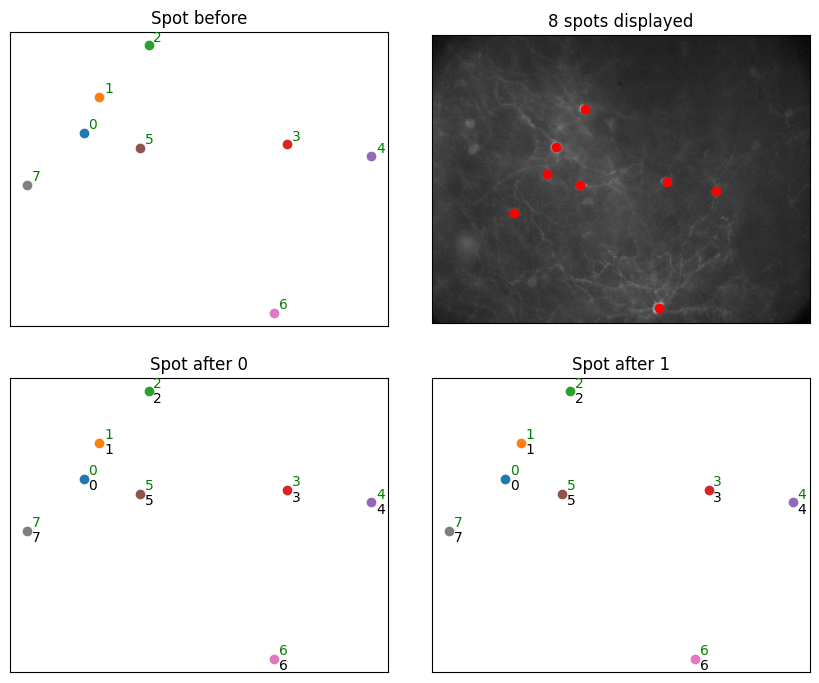

In [474]:
"""
    Variables
    
    DO NOT CHANGE VALUES HERE UNLESS DEBUG/SPECIFIC USE
    
    All the variables used in this part of the cell should always refere to your 'params.py' file
    unless you want to manually change them only for this run (i.e. debugging). 
    You may have to add those variable into the function you want to adapt as only the minimal 
    amount of var are currently given to functions as inputs.
"""
#DH gui folder containing frames
registration_frames = params.registration_frames

#List of all frames available in the registration frame folder
frames_names = os.listdir(registration_frames)

#DH gui folder containing fluorescent images
registration_imgs = params.registration_imgs

#List of all images available in the registration images folder
images_names = os.listdir(registration_imgs)


"""
    Input
"""

#Loading Frames
print("All frames : ")
#Find rec triggers
print(*['{} : {}'.format(i,frame_file) for i, frame_file in enumerate(frames_names)], sep="\n")
sleep(0.5)
frame_number_before = int(input("\nSelect frames for BEFORE drugs: "))
frames_before = frames_names[frame_number_before]
print(f"\nSelected frames BEFORE drugs: {frames_before} \n")

frame_input_after = (input("\nSelect frames for AFTER drugs (press 'ENTER' if same, multiple possible): ")).split()  #May be needed if DH gui had to be restarted during the exp

try:
    assert len(frame_input_after)>0
    frame_number_after = [int(idx) for idx in (frame_input_after)]
    if len(recs_after)>len(frame_number_after):
        frame_number_after += [frame_number_after[-1] for idx in range(len(recs_after)-len(frame_input_after))]
    frames_after = [frames_names[idx] for idx in frame_number_after]

except:
    frame_number_after =-1
    frames_after = [frames_before]*len(recs_after)
    
print(f"\nSelected frames AFTER drugs: {frames_after} \n")

#Image
print("All fluorescent images : ")
#Find rec triggers
print(*['{} : {}'.format(i,img_file) for i, img_file in enumerate(images_names)], sep="\n")
sleep(0.5)
fluorescence_image_path = os.path.normpath(os.path.join(registration_imgs, images_names[int(input("\nSelect image : "))]))
print(f"Image loaded : {fluorescence_image_path}")


"""
    Processing
"""

#Before
dh_frames_before = loadmat(os.path.join(registration_frames, frames_before))
spots_coordinates_before = dh_frames_before["PatternImage"]
order_spots_before=dh_frames_before["OrderFrames"][:,0]


#After
if frame_number_after ==-1:
    dh_frames_after = [dh_frames_before]*len(recs_after)
    spots_coordinates_after = [spots_coordinates_before]*len(recs_after)
    order_spots_after = [order_spots_before]*len(recs_after)

else :
    dh_frames_after = [loadmat(os.path.join(registration_frames, frame)) for frame in frames_after]
    spots_coordinates_after = [dh_frames["PatternImage"] for dh_frames in dh_frames_after]
    order_spots_after = [dh_frames["OrderFrames"][:,0] for dh_frames in dh_frames_after]

spots_equivalence=[]
for frames_after_idx in range(len(dh_frames_after)):
    ### Automatic spot_equivalence
    spots_equivalence_frame={}
    for i, spot1_coord in enumerate(spots_coordinates_before):
        distances=np.zeros(spots_coordinates_after[frames_after_idx].shape[0])
        for j, spot2_coord in enumerate(spots_coordinates_after[frames_after_idx]):
            dist=np.sqrt( ((spot1_coord-spot2_coord)**2).sum() )
            distances[j]=dist
        spots_equivalence_frame[i]=distances.argmin()
    spots_equivalence.append(spots_equivalence_frame)

"""
    Plotting Sanity Check
"""
        
        
fig = plt.figure(figsize=(10,8))
gs = GridSpec(8, 6*(max(2,len(spots_coordinates_after))), left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=1.6, hspace=1.5, figure=fig)

#Spots Before
ax = fig.add_subplot(gs[0:4,0:6])
for spot_nb in range(spots_coordinates_before.shape[0]):
    ax.scatter(spots_coordinates_before[spot_nb][0], spots_coordinates_before[spot_nb][1])
    x=spots_coordinates_before[spot_nb][0]
    y=spots_coordinates_before[spot_nb][1]
    ax.annotate(spot_nb, (x,y), (x+5,y+5), c='g')
    ax.set_title('Spot before')
    ax.set_xticks([])
    ax.set_yticks([])

#Spots After
for frames_after_idx in range(len(dh_frames_after)):
    ax = fig.add_subplot(gs[4:8,6*frames_after_idx:6*(1+frames_after_idx)])
#     for i in range(len(spots_coordinates_after[frames_after_idx])):
    for spot_nb in range(spots_coordinates_after[frames_after_idx].shape[0]):
        plt.scatter(spots_coordinates_after[frames_after_idx][spot_nb][0], spots_coordinates_after[frames_after_idx][spot_nb][1])
        x=spots_coordinates_after[frames_after_idx][spot_nb][0]
        y=spots_coordinates_after[frames_after_idx][spot_nb][1]
        plt.annotate(spot_nb, (x, y), (x+5,y-15))
        plt.annotate(f"{spots_equivalence[frames_after_idx][spot_nb]}", (x, y), (x+5,y+5), c='g')
    ax.set_title(f'Spot after {frames_after_idx}')
    ax.set_xticks([])
    ax.set_yticks([])      

#Image    
ax = fig.add_subplot(gs[0:4,6:12])
im = Image.open(fluorescence_image_path)
ax.imshow(np.array(im)[::-1,:], cmap='gray')
for spot in spots_coordinates_before:
    ax.scatter(spot[0], np.array(im).shape[0]-spot[1], color='r')
ax.set_title("{} spots displayed".format(spots_coordinates_before.shape[0]))
ax.set_xticks([])
ax.set_yticks([])   
plt.show(block=False)

In [498]:
rec_before_after = [rec_before] + recs_after

stim_onsets_before_after = [stim_onsets_before] + stim_onsets_after

spike_times_before_after = [spike_times_before] + spike_times_after

order_spots_before_after = [order_spots_before] + order_spots_after


for i in range(len(stim_onsets_before_after)):

    rec_save = rec_before_after[i]+["_Before" if i == 0 else f'_After_{i}'][0]
    
    stim_onsets = stim_onsets_before_after[i]
    
    order_spots = spike_times_before_after[i]
    
    spike_times = order_spots_before_after[i]

    dict_name = f'{rec_save}_HOLO_dict.pkl'
    print(dict_name)

10_HoloStim1_LAP4+ACET_N19_Z(-25)_Before_HOLO_dict.pkl
15_HoloStim2_TPMPA_t30_N19_Z(-25)_After_1_HOLO_dict.pkl
17_HoloStim3_18BG(10uM)_t10_N19_Z(-25)_After_2_HOLO_dict.pkl


In [478]:
spots_equivalence[frames_after_idx]

2

# Cell 4: Calculate rasters and PSTHS before and after the drug

It requires Cell 1, Cell 2 and Cell 3 to be run

In [442]:
def get_sequences_laser_triggers(triggers, order_spots, duration_repetition = 1, time_before = 0.25):
    
    """
    Transform a list of laser spots into the right dict format for classic vec analysis
    """
    
    assert len(triggers) == len(order_spots), "Mismatching between numbers of triggers and of spots given as input"
    
    trig_seq_dict = get_sequences_triggers(triggers, order_spots) #get a dictionnary of all triggers for each spot
    tri_seq       = {key: [(np.arange(trig-time_before, trig-time_before+duration_repetition,time_before)) for trig in triggers] for key, triggers in trig_seq_dict.items()}
    return {f"1{key}{rep_key:02d}": seq_trig for key, triggers in tri_seq.items() for rep_key, seq_trig in enumerate(triggers)}

In [500]:
stim_onsets

array([ 10.     ,  12.406  ,  13.41915,  14.42285,  15.42775,  16.43925,
        17.44335,  18.44555,  19.44885,  20.45175,  21.45445,  22.45695,
        23.45925,  24.4619 ,  25.46365,  26.46615,  27.4692 ,  28.4722 ,
        29.4755 ,  30.47795,  31.48035,  32.4834 ,  33.4857 ,  34.48815,
        35.49095,  36.4935 ,  37.49615,  38.4985 ,  39.50115,  40.5035 ,
        41.50585,  42.5081 ,  43.511  ,  44.5131 ,  45.51545,  46.51815,
        47.52045,  48.5233 ,  49.52495,  50.52755,  51.529  ,  52.53175,
        53.5332 ,  54.6883 ,  55.6906 ,  56.69135,  57.6939 ,  58.69575,
        59.69705,  60.6994 ,  61.70205,  62.7039 ,  63.70645,  64.70975,
        65.71025,  66.7115 ,  67.7133 ,  68.7156 ,  69.7172 ,  70.7192 ,
        71.7215 ,  72.7242 ,  73.72645,  74.7294 ,  75.7325 ,  76.73505,
        77.7373 ,  78.73875,  79.74115,  80.7427 ,  81.74465,  82.7471 ,
        83.7498 ,  84.7526 ,  85.75475,  86.7569 ,  87.7586 ,  88.7609 ,
        89.76295,  90.76485,  91.76635,  92.7693 , 

In [501]:
order_spots

{21: array([], dtype=float64),
 23: array([ 39.00015,  69.60985, 187.0009 , 188.87815, 322.40635]),
 54: array([ 43.4192 ,  86.18365,  86.19265, 172.8014 , 191.72845, 215.5228 ,
        309.5872 , 390.885  ]),
 60: array([187.0013, 278.1512, 383.9054]),
 67: array([187.     , 277.73865]),
 76: array([], dtype=float64),
 90: array([119.4106, 249.1963]),
 102: array([], dtype=float64),
 103: array([], dtype=float64),
 104: array([148.34825, 148.355  , 230.25385, 230.27655, 258.3227 , 258.32955,
        316.28645, 316.29465, 316.3118 , 316.3318 , 316.4034 , 316.63585,
        317.1435 ]),
 106: array([ 41.39015,  41.42535,  41.46885,  41.5219 ,  93.2976 ,  96.17805,
        108.7944 , 112.77735, 112.7925 , 171.6119 , 282.60835, 315.9546 ,
        315.962  , 315.9673 , 316.02   , 316.0236 , 316.0328 , 316.05705,
        316.0821 , 316.09645, 316.097  , 316.1179 , 316.2628 , 316.3712 ,
        316.4623 , 316.49685, 316.6246 , 337.9797 , 356.20695, 357.9361 ,
        366.33035, 366.33925, 36

In [525]:
spots_equivalence

[{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7},
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}]

In [530]:
spots_equivalence[rec_idx-1][int(key)]

6

In [533]:
set(order_spots)

{1, 2, 3, 4, 5, 6, 7, 8}

In [534]:
"""
    Input
"""

n_bin=40          # binning for the psth, default = 40
# n_bin ='relative' # if n_bin = "relative", n_bin = sqrt(nb of spikes in the raster)

nb_triggers_by_repetition = 1
spot_duration= 0.5
duration_repetition = 1
bin_size = 0.050
time_before_stim=0.25   # in seconds

"""
    Variables
"""

rec_before_after = [rec_before] + recs_after

stim_onsets_before_after = [stim_onsets_before] + stim_onsets_after

spike_times_before_after = [spike_times_before] + spike_times_after

order_spots_before_after = [order_spots_before] + order_spots_after

"""
    Processing
"""

for rec_idx in range(len(stim_onsets_before_after)):

    rec_save = rec_before_after[rec_idx]+["_Before" if rec_idx == 0 else f'_After_{rec_idx}'][0]
    
    stim_onsets = stim_onsets_before_after[rec_idx]
    
    order_spots = order_spots_before_after[rec_idx]

    spike_times = spike_times_before_after[rec_idx]
        
    
    dict_name = f'{rec_save}_HOLO_dict.pkl'
    
    print(f"{rec_save} : \nSplitting spikes into sequences for each cluster...")
    rec_dict = {}
    sorted_data = {}

    trig_seq = get_sequences_laser_triggers(stim_onsets[-len(order_spots):], order_spots)                                                        # the - sign here takes the spot from the end of the triggers
                                                         # Create a dictionnary with sequence keys including repetion number
                                                         # as key and a list of all the triggers in this repetition seq
                                                         # {"rep_seq_key" : [float]}
    for i in tqdm(cells):

        #Process
        rec_dict[i]={}
        spike_seq = get_spikes_sequences(spike_times[i], trig_seq) # Create a dictionnary for each cluster with sequence keys including repetion number
                                                                   # as key and a list of all the spikes in this repetition seq 
                                                                   # {"rep_seq_key" : [float]}

        raster    = spikeseq2raster(spike_seq, trig_seq)           # Create a dictionnary for each cluster with sequence types keys 
                                                                   # as key and a list of all the repetition of this sequence type (raster of the sequence type) 
                                                                   # {"seq_type_key" : [np.arrays]}

        psth      = spikeseq2psth(raster, trig_seq, n_bin=n_bin)   # Create a dictionnary for each cluster with sequence types keys 
                                                                   # as key and a binning of the raster 
                                                                   # {"seq_type_key" : np.array (len(n_bin))}

        #Cluster all data in a dict {Cell_id : {"seq_type_key": {'raster': [np.arrays]; 'psth':np.array (len(n_bin)) }  }   }
        sorted_data[i] = spike_seq
        for key in raster.keys():
            if key=='': continue
            
            elif rec_idx>=1:
                dict_key = spots_equivalence[rec_idx-1][int(key)-1]  #takes the same spots numerotation for all recs
            else:
                dict_key = key
            
            rec_dict[i][dict_key]={}
            rec_dict[i][dict_key]['raster']   = raster[key]
            rec_dict[i][dict_key]['psth']     = psth[key]

            #Add the necessary info for plotting about the seq length and triggers taking the repetition number 0 of this seqence type
            rec_dict[i][dict_key]['triggers'] = {
                'start':trig_seq['1'+key+'00'][0], 
                'end':trig_seq['1'+key+'00'][-1], 
                'rng':(0, trig_seq['1'+key+'00'][-1]-trig_seq['1'+key+'00'][0] + np.mean(np.diff(trig_seq['1'+key+'00']))),
                }   

    # Saving all dict generated
    print("Saving...")
    save_obj(rec_dict, os.path.join(Holo_directory, dict_name))
    save_obj(trig_seq, os.path.join(Holo_directory, f'{rec_save}_Sorted_triggers.pkl'))
    save_obj(sorted_data, os.path.join(Holo_directory, f'{rec_save}_Sorted_Spikes.pkl'))


#     del sorted_data 
print("----- Done -----")

10_HoloStim1_LAP4+ACET_N19_Z(-25)_Before : 
Splitting spikes into sequences for each cluster...


  0%|          | 0/212 [00:00<?, ?it/s]

Saving...
15_HoloStim2_TPMPA_t30_N19_Z(-25)_After_1 : 
Splitting spikes into sequences for each cluster...


  0%|          | 0/212 [00:00<?, ?it/s]

Saving...
17_HoloStim3_18BG(10uM)_t10_N19_Z(-25)_After_2 : 
Splitting spikes into sequences for each cluster...


  0%|          | 0/212 [00:00<?, ?it/s]

Saving...
----- Done -----


In [712]:
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


# Function to plot raster
def plot_raster(ax, spot_data):
    ax.eventplot(spot_data['raster'], linewidths=5)
    ax.set_ylabel('Rep')
    
    ax.set_xlim(spot_data['triggers']['rng'])
    ax.set_ylim((0,len(spot_data['raster'])-1))
    
    y_ticks = [i*5-1 for i in range(1, len(spot_data['raster'])//5+1)]
    
    
    ax.set_yticks(y_ticks, labels=np.array(y_ticks)+1)
    ax.set_xticks([])
    
    
# Function to plot PSTH
def plot_psth(ax, spot_data, x_axis=None):
    x = np.linspace(0,spot_data['triggers']['rng'][1], len(spot_data["psth"]))
    ax.plot(x, spot_data["psth"]/max(spot_data["psth"]), linewidth=5)
    ax.set_xlabel('Time')
    ax.set_ylabel('Rate')
    ax.set_ylim(bottom = 0)
    ax.set_xlim(spot_data['triggers']['rng'])
    if x_axis:
        ax.set_xticks(x_axis)
    else:
        ax.set_xticks(np.linspace(0,spot_data['triggers']['rng'][1], 5), labels = (np.round(np.linspace(0,spot_data['triggers']['rng'][1], 5))))
    ax.set_yticks([0,0.5,1])

    
def plot_rasterXpsth(spot_data, fig=None, main_gs=None, ratio=3, x_axis=None):
    from matplotlib.gridspec import GridSpecFromSubplotSpec
    if not fig:
        fig=plt.figure()
        main_gs=GridSpec(1,1, figure = fig)[0]
        
    nested_gs = GridSpecFromSubplotSpec(2, 1, subplot_spec=main_gs, height_ratios=[ratio, 1], hspace = .0)
    
    raster_ax = fig.add_subplot(nested_gs[0])
    plot_raster(raster_ax, spot_data)

    psth_ax = fig.add_subplot(nested_gs[1])
    plot_psth(psth_ax, spot_data, x_axis=x_axis)
    
    return nested_gs, raster_ax, psth_ax



In [713]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import matplotlib
import time
"""
    Input
"""

ratio=3
col_names = ["Before", "After drug 1", "After drug 2"]

"""
    Variables
"""

rec_before_after = [rec_before] + recs_after

colors = ['purple', '#CC6600', 'teal']

"""
    Plotting
"""

n_col = len(rec_before_after)+1

data = [load_obj(os.path.join(Holo_directory, f"{rec_before_after[i]+['_Before' if i == 0 else f'_After_{i}'][0]}_HOLO_dict.pkl")) for i in range(n_col-1)]


# Plotting
for cell_id in tqdm(data[0].keys()):
    
    if cell_id!=187:
        continue
    
    fig = plt.figure(figsize=(3*ratio*n_col+1, 3*ratio*len(data[0][cell_id])))
    params = {'axes.labelsize': 50, 'legend.fontsize': 30, 'xtick.labelsize': 30, 'ytick.labelsize': 30, "axes.linewidth": 3}
    matplotlib.rcParams.update(params)  

    
    gs  = GridSpec(len(data[0][cell_id]), n_col, figure=fig, wspace=0.15, hspace=0.25)
    
        
    combined_psth=[fig.add_subplot(gs[row,n_col-1]) for row in range(len(data[0][cell_id]))]
    
    for col in range(n_col-1):
        cell_data = data[col][cell_id]
        for row, (spot_id, spot_data) in enumerate(cell_data.items()):
            
            ###### PLOTING ######
            rasterXpsth, raster, psth = plot_rasterXpsth(spot_data, fig, gs[row,col], x_axis = [0.25,0.75])
            
            combined_psth[row].plot(np.linspace(0,spot_data['triggers']['rng'][1], len(spot_data["psth"])), spot_data['psth'], color=colors[col], label=col_names[col], linewidth=5, alpha=0.5)
            
            
            
            ###### Decoration ######
            
            #Changing colors
            for collection in raster.collections:
                collection.set_color(colors[col])
            psth.lines[0].set_color(colors[col])
            
            
            #adding the laser pulse display
            raster.axvspan(0.25, 0.75, alpha=0.05, color='red')
            raster.axvline(0.25, color='red', linestyle='--')
            raster.axvline(0.75, color='red', linestyle='--')

            psth.axvspan(0.25, 0.75, alpha=0.05, color='red')
            psth.axvline(0.25, color='red', linestyle='--')
            psth.axvline(0.75, color='red', linestyle='--')   
            
            combined_psth[row].axvspan(0.25, 0.75, alpha=0.05, color='red')
            combined_psth[row].axvline(0.25, color='red', linestyle='--')
            combined_psth[row].axvline(0.75, color='red', linestyle='--') 
            
            
            #Dealing with labels and stuff
            if row == len(data[0][cell_id])-1:
                combined_psth[row].set_xlabel('Time')
            elif row == 0:
                combined_psth[row].legend()
                raster.set_title(col_names[col], fontsize=60)
                psth.set_xlabel('')
            else:
                psth.set_xlabel('')
                          

            
            if col == 0:
                raster.annotate(f'Spot {spot_id}', (-0.3, 0.29), fontsize=80, xycoords='axes fraction', va='center', rotation=90)
                raster.set_yticks([])
                psth.set_yticks([]) 
            elif col == n_col-2:
                raster.yaxis.tick_right()
                
                psth.yaxis.tick_right()
                raster.set_ylabel('')
                psth.set_ylabel('')
                
                combined_psth[row].yaxis.tick_right()
                combined_psth[row].yaxis.set_label_position("right")
                combined_psth[row].set_ylabel('Firing Rate')
                combined_psth[row].set_ylim(bottom=0)
                combined_psth[row].set_xticks([0.25,0.75])
                
            else:
                raster.set_yticks([])
                psth.set_yticks([]) 
                raster.set_ylabel('')
                psth.set_ylabel('')

                


    plt.suptitle(f'Cell {cell_id}', fontsize=100)
    plt.savefig(os.path.join(Holo_directory, f"plots/Cell_{cell_id}.png"))
    plt.close('all')
    
    

  0%|          | 0/212 [00:00<?, ?it/s]

# Cell 5: Plotting. RGC specific activation

It requires Cell 4 to be run

In [13]:
registration_directory=params.registration_directory
XWorldLimits, YWorldLimits, ImageSize = load_image_infos(os.path.join(registration_directory,"sta_infos.mat"), key_name="sta_infos")

#these are the coordinates of the holographic spots in the MEA frame of reference. Their frame of reference
#does not start from 0
dh_points_mea = loadmat(os.path.join(registration_directory,"dh_points_mea.mat"))['dh_points_mea']
nb_spots=dh_points_mea.shape[0]

#offset them so that they do start from zero like the reference frame in which the ellipse was fitted
offsetted_spots_coords = np.zeros(dh_points_mea.shape)
for i_spot in range(nb_spots):
    spot_coord = dh_points_mea[i_spot]
    offsetted_spots_coords[i_spot] = spot_coord-np.array([XWorldLimits[0], YWorldLimits[0]])
    
fig_directory = os.path.normpath(os.path.join(output_directory,r'Holo_flash_figs/RGC_specific_response'))
if not os.path.isdir(fig_directory): os.makedirs(fig_directory)
    
sta_results=np.load(os.path.join(output_directory,'sta_data_3D_fitted.pkl'),allow_pickle=True)
Chirp_data = np.load(os.path.join(output_directory, '{}_cell_typing_data.pkl'.format(exp)), allow_pickle=True)
registered_ellipses = np.load(os.path.join(output_directory, 'Well_fitted_registered_ellipses.npy'), allow_pickle=True).item()
Distances= np.load(os.path.join(output_directory,'{}_RF_Holo_spots_distances.npy'.format(exp)), allow_pickle=True).item()
cells=list(Chirp_data.keys())

#generate customized colormap
cmap = plt.cm.get_cmap('gist_ncar')  #turbo
colors=np.linspace(0,0.9, nb_spots)
col_list=[]
for color in colors:
    rgba = cmap(color)
    col_list.append(rgba)

labels=['control', '18BG+20']
colors=['blue', 'orange']
    
for cell_nb in tqdm(cells[:]):
        
    if Chirp_data[cell_nb]['type']=='Not assigned': cluster=''
    else: cluster = Chirp_data[cell_nb]['type']
    
    #find cell's max firing rate for plotting purposes
    max_fr=0
    for rec in recordings:
        for spot_nb in range(nb_spots):
            if np.mean(analyse[cell_nb][rec][spot_nb]['binned_sp_trains'], axis=0).max()>max_fr:
                max_fr=np.mean(analyse[cell_nb][rec][spot_nb]['binned_sp_trains'], axis=0).max()
    
    fig = plt.figure(figsize=(3*(nb_recs_after+2),2*nb_spots+2))
    gs = GridSpec(3*nb_spots+6, 5*(nb_recs_after+2)+3+6, left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.4, hspace=1.5, figure=fig)
    
    #plot spatial STA
    ax = fig.add_subplot(gs[0:4, 0:4])
    ax.set_title("STA",fontsize=12 )
    spatial = sta_results[cell_nb]['center_analyse']['Spatial']
    spatial = spatial**2*np.sign(spatial)
    cmap='RdBu_r'
    image = ax.imshow(spatial, cmap=cmap,interpolation='gaussian')
    abs_max = 0.5*max(np.max(spatial), abs(np.min(spatial)))
    image.set_clim(-abs_max,abs_max)
    ax.set_xticks([])
    ax.set_yticks([])
    
    #plot the 40x fluorescence image with the spots positions
    ax = fig.add_subplot(gs[3:6,0:6])
    im = Image.open(fluorescence_image_path)
    ax.imshow(np.array(im)[:,:,0][::-1,:], cmap='gray')
    for spot_nb, spot in enumerate(spots_coordinates_before):
        ax.scatter(spot[0], np.array(im)[:,:,0].shape[0]-spot[1], s=5, color=col_list[spot_nb])
        ax.annotate(spot_nb, (spot[0],np.array(im)[:,:,0].shape[0]-spot[1]), (spot[0],np.array(im)[:,:,0].shape[0]-spot[1]))
#     ax.set_title("{} spots displayed".format(spots_coordinates_before.shape[0]))
    ax.set_xticks([])
    ax.set_yticks([])
    
    distance=False
    if cell_nb in Distances.keys(): distance=True
    
    if distance:
        
        #find cell's bigger relative distance for plotting purposes
        max_rel_dist=0
        for spot_nb in range(nb_spots):
            if Distances[cell_nb][spot_nb]['relative_distance']>max_rel_dist: max_rel_dist=Distances[cell_nb][spot_nb]['relative_distance']
    
        
        #plot the ellipse and the holographic spots with their absolute distance
        ax = fig.add_subplot(gs[0:6,6:15])
        for spot_nb in range(nb_spots):
            spot_coord = offsetted_spots_coords[spot_nb]
            ax.scatter(spot_coord[0], spot_coord[1], s=25, color=col_list[spot_nb])
            ax.annotate(int(np.round(Distances[cell_nb][spot_nb]['absolute_distance'],0)), (spot_coord[0],spot_coord[1]), (spot_coord[0]+15,spot_coord[1]+15), fontsize=8)
        
        ell_params=registered_ellipses[cell_nb]
        x,y=ell_params[1:3]
        ellipse,_,_=get_ellipse(ell_params, factor=2)
        ax.scatter(x,y, color='black', s=10)
        ax.scatter(ellipse[0], ellipse[1], s=0.5)

        ax.set_xlim([x-400, x+400])
        ax.set_ylim([y-400, y+400])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.invert_yaxis()
        ax.set_title('Absolute Distances (um)', fontsize=12)
    
        #initialize the relative distance scatter plot
        ax_scatter = fig.add_subplot(gs[0:5,17:])
        ax_scatter.set_title('Relative distance vs Activation', fontsize=12)
        ax_scatter.axvline(1, ls='--', color='grey')
        ax_scatter.axhline(0, ls='-', color='k')
        ax_scatter.set_xlim([0, max_rel_dist+0.5])
        ax_scatter.set_xlabel('Relative distance', fontsize=12)
        ax_scatter.set_ylabel('Cell activation',labelpad=0.001 , fontsize=12)
    
        #reorder the spots by their distance from the RF
        spots_abs_dists=[]
        for spot_nb in range(nb_spots):
            spots_abs_dists.append(Distances[cell_nb][spot_nb]['absolute_distance'])
        reord_spots=np.array(spots_abs_dists).argsort()
        
    if distance: spots_order = reord_spots
    else: spots_order = range(nb_spots)
    
    for spot_idx, spot_nb in enumerate(spots_order):
        for idx, flag in enumerate(list([0]+recordings)):
            
            ax = fig.add_subplot(gs[6+spot_idx*3:6+(spot_idx+1)*3, idx*5+3:(idx+1)*5+3])
            #plotting PSTHS
            if flag==0:
                for rec_id, rec in enumerate(recordings):
                    binned_reps=analyse[cell_nb][rec][spot_nb]['binned_sp_trains']
                    psth = np.mean(binned_reps, axis=0) 
                    ax.plot(psth, label=labels[rec_id], color=colors[rec_id])
                    
                    if max_fr!=0: ax.set_ylim([0,max_fr])
                    ax.set_yticks([])
                    ax.set_xticks([time_before_stim/bin_size, (time_before_stim+spot_duration)/bin_size], [0, spot_duration])
                    if spot_idx==0:ax.legend()
                    for j in [time_before_stim/bin_size, (time_before_stim+spot_duration)/bin_size]:
                        ax.axvline(j, ls='--',color='grey')
                    if spot_idx==nb_spots-1: ax.set_xlabel('Time (s)')
                    
                    
                    baseline_activity = binned_reps[:, :int(time_before_stim/bin_size)]
                    baseline_activity_per_rep = np.mean(baseline_activity, axis=1)
                    mean_off_time = np.mean(baseline_activity_per_rep)
                    std_off_time = np.std(baseline_activity_per_rep)/np.sqrt(baseline_activity_per_rep.size)
                    
                    activity_during_spot = binned_reps[:, int(time_before_stim/bin_size):int((time_before_stim+spot_duration)/bin_size)]
                    activity_during_spot_per_rep = np.mean(activity_during_spot, axis=1)
                    mean_on_time = np.mean(activity_during_spot_per_rep)
                    std_on_time = np.std(activity_during_spot_per_rep) /np.sqrt(activity_during_spot_per_rep.size)
                
                    peak_on_time = psth[int(time_before_stim/bin_size):int((time_before_stim+spot_duration)/bin_size)].max()
                    std_on_psth_across_time=np.std(psth[int(time_before_stim/bin_size):int((time_before_stim+spot_duration)/bin_size)])
                    
                    is_cell_transient = peak_on_time-mean_on_time-2.5*std_on_psth_across_time
                    
                    if rec_id==0 and is_cell_transient > 0: # if the cell is detected as transient
                        if mean_off_time==0 or mean_off_time-3*std_off_time<0: 
                            if mean_on_time==0 or mean_on_time-3*std_on_time<0:
                                activation=0
                                activation_err=std_on_time
                            else:
                                activation=peak_on_time
                                activation_err=0
                        else:
                            activation=(peak_on_time-mean_off_time)/mean_off_time
                            activation_err = std_off_time
                    if rec_id==0 and is_cell_transient < 0: # if the cell is detected as sustained
                        if mean_off_time==0 or mean_off_time-3*std_off_time<0:
                            if mean_on_time==0 or mean_on_time-3*std_on_time<0:
                                activation = 0
                                activation_err = std_on_time 
                            else:
                                activation = mean_on_time
                                activation_err = std_on_time
                        else:
                            activation=(mean_on_time-mean_off_time)/mean_off_time
                            activation_err = np.abs(mean_on_time/mean_off_time)*np.sqrt( (std_on_time/mean_on_time)**2 + (std_off_time/mean_off_time)**2 )
                    if rec_id==0 and is_cell_transient == 0.:
                        activation = 0
                        activation_err = 0
                        
#                     print('Spot{}: activation {}, type {} '.format(spot_nb,activation,is_cell_transient))
#                     print(mean_off_time, mean_on_time, peak_on_time)
#                     print(activation_err, std_on_time, std_off_time)
                    if rec_id==0: 
                        if distance:
                            #scatter a point in the relative distance scatter pplot
                            ax_scatter.scatter(Distances[cell_nb][spot_nb]['relative_distance'], activation, color=col_list[spot_nb])
                            ax_scatter.annotate(spot_nb, (Distances[cell_nb][spot_nb]['relative_distance'],activation), (Distances[cell_nb][spot_nb]['relative_distance']+0.1,activation+0.1), fontsize=8)
                            ax_scatter.errorbar(Distances[cell_nb][spot_nb]['relative_distance'],activation,yerr=activation_err,color=col_list[spot_nb],  linestyle="-", lw=0.5)
                    
                        #plot a bar plot with the PSTHs averages per each spot
                        ax_bar = fig.add_subplot(gs[6+spot_idx*3:6+(spot_idx+1)*3, 0:3])
                        errors=[std_off_time, std_on_time, 0]
                        ax_bar.bar([0.2, 0.4, 0.6], [mean_off_time, mean_on_time, peak_on_time],yerr=errors, width=0.1, color=['blue','red','crimson'])
                        if max_fr!=0: ax_bar.set_ylim([0, max_fr])
                        ax_bar.set_xticks([])
                        ax_bar.set_ylabel('Spot {}'.format(spot_nb), fontsize=20)
                        if spot_idx==1: ax_bar.set_title('Modulation in Hz', fontsize=8)
                        if spot_idx==nb_spots-1:
                            ax_bar.set_xticks([0.2, 0.4, 0.6], ['mean_OFF', 'mean_ON', 'peak_ON'], rotation=45)
            else:
                #plotting Rasters
                ax.eventplot(analyse[cell_nb][flag][spot_nb]['spike_trains'], color=colors[idx-1])
                ax.set_ylim([0,nb_repetitions])
                ax.set_xlim([-time_before_stim,spot_duration+time_before_stim])
                ax.set_yticks([])
                if spot_idx==0: ax.set_title('{}'.format(labels[idx-1]))
                ax.set_xticks([0, spot_duration], [0, spot_duration])
                for j in [0, spot_duration]:
                    ax.axvline(j, ls='--',color='grey')
                if spot_idx==nb_spots-1: ax.set_xlabel('Time (s)')
        

    fig.suptitle('Ganglion cell {}, all spots \n Cell_group {}'.format(cell_nb, cluster), fontsize=35)
    fig_file = os.path.join(fig_directory,f'Group_{cluster}_Cell_{cell_nb}.png')
    plt.savefig(fig_file, dpi=fig.dpi)
    plt.close()

FileNotFoundError: [Errno 2] No such file or directory: '20231125_VIP.Project_FF+Disk_100um_DHguiOptimization/sta_infos.mat'

In [14]:
np.where(np.array(cells)==157)

(array([], dtype=int64),)

# Cell6: Plotting. Amacrine specific activation

This plot is generated including only the cells that had a good transformed ellipse fitting and so they have a measure of distance from the Amacrine cell

Requires cell 4 to be run

In [ ]:
Chirp_data = np.load(os.path.join(output_directory, '{}_cell_typing_data.pkl'.format(exp)), allow_pickle=True)
registered_ellipses = np.load(os.path.join(output_directory, 'Well_fitted_registered_ellipses.npy'), allow_pickle=True).item()
Distances= np.load(os.path.join(output_directory,'{}_RF_Holo_spots_distances.npy'.format(exp)), allow_pickle=True).item()

cells= list(Distances.keys())

cell_clusters={}
cell_clusters['Not assigned']=[]
for cell_nb in cells:
    cell_type=Chirp_data[cell_nb]['type']
    if cell_type not in cell_clusters.keys(): cell_clusters[cell_type]=[]
    cell_clusters[cell_type].append(cell_nb)
    
nb_clusters=len(list(cell_clusters.keys()))-1
nb_non_assigned_cells=len(cell_clusters['Not assigned'])
nb_cells_in_bigger_cluster=0
for i in range(nb_clusters):
    print('Cluster {}: {} cells \t {}'.format(i, len(cell_clusters[i]), cell_clusters[i]) )
    if len(cell_clusters[i])>nb_cells_in_bigger_cluster: nb_cells_in_bigger_cluster=len(cell_clusters[i])
    
print(nb_clusters, nb_cells_in_bigger_cluster, nb_non_assigned_cells)

In [ ]:
fig_directory = os.path.normpath(os.path.join(output_directory,r'Holo_flash_figs/Spot_specific_response'))
if not os.path.isdir(fig_directory): os.makedirs(fig_directory)

DH_frames_filepath = r"/media/samuele/VIP.Project_18BG/VIP.Project/20220912_VIP.Project_18betaG.10uM/20220912_DHguiOptimization_VIP.Project_18BetaG/frames/DH_frames_20220912_18_28_12" ### change here
dh_frames = loadmat(DH_frames_filepath)
#an array with the coordinates of all the spots in the 40x reference
spots_coordinates_before = dh_frames["PatternImage"]
fluorescence_image_path = r"/media/samuele/VIP.Project_18BG/VIP.Project/20220912_VIP.Project_18betaG.10uM/20220912_DHguiOptimization_VIP.Project_18BetaG/imgs/Retina_40x_Position2_(-60).jpg" ### change here

XWorldLimits, YWorldLimits, ImageSize = load_image_infos(os.path.join(registration_directory,"sta_infos.mat"), key_name="sta_infos")

#these are the coordinates of the holographic spots in the MEA frame of reference. Their frame of reference
#does not start from 0
dh_points_mea = loadmat(os.path.join(registration_directory,"dh_points_mea.mat"))['dh_points_mea']
nb_spots=dh_points_mea.shape[0]

#offset them so that they do start from zero like the reference frame in which the ellipse was fitted
offsetted_spots_coords = np.zeros(dh_points_mea.shape)
for i_spot in range(nb_spots):
    spot_coord = dh_points_mea[i_spot]
    offsetted_spots_coords[i_spot] = spot_coord-np.array([XWorldLimits[0], YWorldLimits[0]])

labels=['control', '18BG+20']
colors=['blue', 'orange']
    
nb_columns=nb_clusters+int(nb_non_assigned_cells/nb_cells_in_bigger_cluster)+1
for spot_nb in tqdm(range(nb_spots)[:]):

    fig = plt.figure(figsize=(3*nb_columns,2*nb_cells_in_bigger_cluster+3))
    gs = GridSpec(3*nb_cells_in_bigger_cluster+5, 5*(nb_columns), left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=2.5, hspace=1.5, figure=fig)  
    
    for clus_idx in range(nb_columns):
        if clus_idx<nb_clusters:
            #initilize the mosaic
            mosaic= fig.add_subplot(gs[0:5, clus_idx*5: clus_idx*5+5])
            spot_coord = offsetted_spots_coords[spot_nb]
            mosaic.scatter(spot_coord[0], spot_coord[1], s=25, color='red')
            mosaic.annotate(spot_nb, (spot_coord[0],spot_coord[1]), (spot_coord[0]+2,spot_coord[1]+2), fontsize=8)
            mosaic.set_title('Group {}'.format(clus_idx))
            mosaic.set_xticks([])
            mosaic.set_yticks([])
            mosaic.invert_yaxis()
            
            #find spot's max firing rate for this cell type for plotting purposes
            max_fr=0
            for rec in recordings:
                for cell in cell_clusters[clus_idx]:
                    if np.mean(analyse[cell][rec][spot_nb]['binned_sp_trains'], axis=0).max()>max_fr:
                        max_fr=np.mean(analyse[cell][rec][spot_nb]['binned_sp_trains'], axis=0).max()
            
            #reorder the GCs by their distance from the holo spot
            rgcs_abs_dists=[]
            for cell in cell_clusters[clus_idx]:
                rgcs_abs_dists.append(Distances[cell][spot_nb]['absolute_distance'])
            reordered_rgcs=np.array(cell_clusters[clus_idx])[np.array(rgcs_abs_dists).argsort()]
            
            for row, cell in enumerate(reordered_rgcs):
                
                #plot the holo spot psth of all the cells in the given cluster, ordered by absolute distance
                ax = fig.add_subplot(gs[3*row+5:5+(row+1)*3, clus_idx*5: (clus_idx+1)*5])
        
                for rec_id, rec in enumerate(recordings):
                    binned_reps=analyse[cell][rec][spot_nb]['binned_sp_trains']
                    psth = np.mean(binned_reps, axis=0) 
                    ax.plot(psth, label=labels[rec_id], color=colors[rec_id])
                    ax.set_title('Cell {}'.format(cell))
                    ax.set_ylabel("{}".format(row))
                    if max_fr!=0: ax.set_ylim([0,max_fr])   #scale the plots according to the most firing cell of this type
                    ax.set_xticks([time_before_stim/bin_size, (time_before_stim+spot_duration)/bin_size], [0, spot_duration])
                    if row==0:ax.legend()
                    for j in [time_before_stim/bin_size, (time_before_stim+spot_duration)/bin_size]:
                        ax.axvline(j, ls='--',color='grey')
                    if row==len(cell_clusters[clus_idx])-1: ax.set_xlabel('Time (s)')
                
                #plot an ellipse in the cell type mosaic
                ell_params=registered_ellipses[cell]
                x,y=ell_params[1:3]
                mosaic.scatter(x, y, color='black', s=0.3) #color=col_list[spot_nb]
                mosaic.annotate(row, (x,y), (x+0.1,y+0.1), fontsize=8)
                ellipse,_,_=get_ellipse(ell_params, factor=2)
                mosaic.scatter(ellipse[0], ellipse[1], s=0.1)
        else:
            #plot the psths of the cells that were not clustered
            for row, cell in enumerate(cell_clusters['Not assigned']):
                
                new_row = row%nb_cells_in_bigger_cluster
                new_column = int(row/nb_cells_in_bigger_cluster)
                
                #plot the holo spot psth of all the cells 
                ax = fig.add_subplot(gs[3*new_row+5:5+(new_row+1)*3, nb_clusters*5+new_column*5: nb_clusters*5+(new_column+1)*5])
                if row==0: ax.set_title('Non clustered')
                for rec_id, rec in enumerate(recordings):
                    binned_reps=analyse[cell][rec][spot_nb]['binned_sp_trains']
                    psth = np.mean(binned_reps, axis=0) 
                    ax.plot(psth, label=labels[rec_id], color=colors[rec_id])
                    ax.set_title('Cell {}'.format(cell))
                    ax.set_ylabel("{}".format(row))
#                     if max_fr!=0: ax.set_ylim([0,max_fr])   #scale the plots according to the most firing cell of this type
                    ax.set_xticks([time_before_stim/bin_size, (time_before_stim+spot_duration)/bin_size], [0, spot_duration])
                    if row==0:ax.legend()
                    for j in [time_before_stim/bin_size, (time_before_stim+spot_duration)/bin_size]:
                        ax.axvline(j, ls='--',color='grey')
                    if row==nb_cells_in_bigger_cluster-1: ax.set_xlabel('Time (s)')
    
    
    fig.suptitle('Spot {}, all gangliion cells'.format(spot_nb), fontsize=35)
    fig_file = os.path.join(fig_directory,f'Spot_{spot_nb}.png')
    plt.savefig(fig_file, dpi=fig.dpi)
    plt.close()